In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
# Place this at the top of your notebook

%matplotlib inline

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# imbalance  
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('network_traffic.csv')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,is_intrusion
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,tcp,http,SF,302.0,896.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,tcp,http,SF,339.0,1588.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,tcp,http,SF,260.0,7334.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,tcp,http,SF,213.0,8679.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# Generate the profile report
profile = ProfileReport(df, title="Y-Data Profiling Report", explorative=True)

# To view the report in a Jupyter Notebook
profile.to_notebook_iframe()

# Alternatively, export the report to an HTML file
profile.to_file("ydata_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### According to the result, land, urgent, and wrong_fragment have only one unique value .
##### we can drop them because these features don't add any variability and might not contribute much to the predictive modeling process

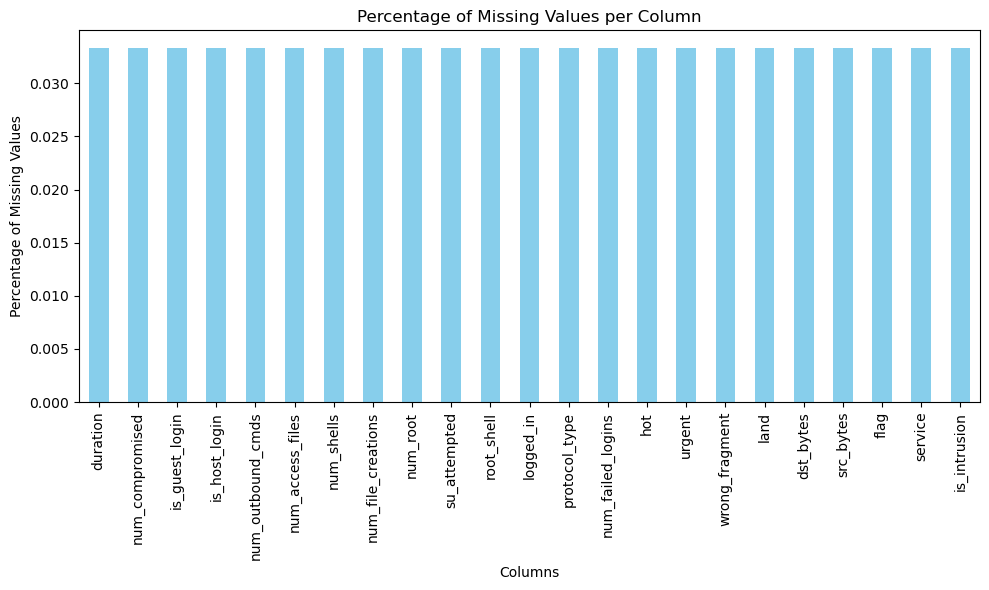

In [5]:
# Calculate the percentage of missing values for each column
missing_percent = df.isnull().mean() * 100

# Plot the missing values in a bar plot
plt.figure(figsize=(10, 6))
missing_percent[missing_percent > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


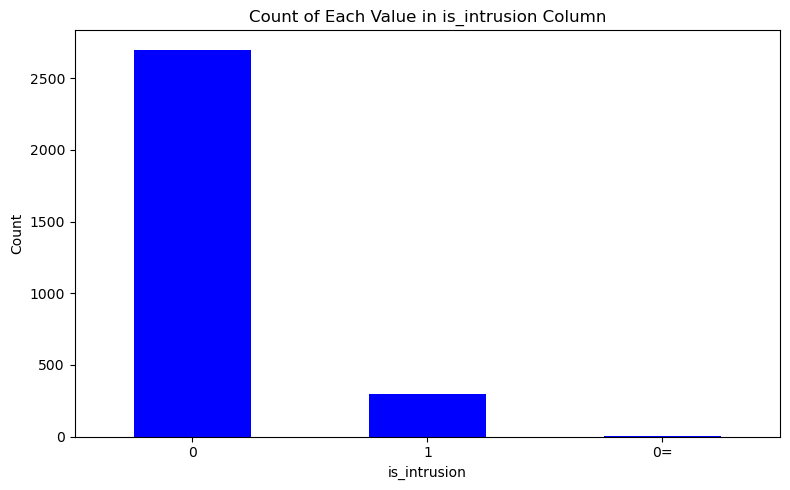

In [6]:
# Plot the count of each unique value in the 'is_intrusion' column

plt.figure(figsize=(8, 5))
df['is_intrusion'].value_counts().plot(kind='bar', color='blue')
plt.title('Count of Each Value in is_intrusion Column')
plt.xlabel('is_intrusion')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
## There are some mistypes.

In [7]:
# Data Preparation
# Identify columns with only one unique value
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]

# Drop columns with only one unique value
df_dropped = df.drop(columns=columns_to_drop)

In [8]:
# Drop rows with missing values
df_clean = df_dropped.dropna()
# Replace 0= with 0 in the 'is_intrusion' column
# Replace '0=' with 0 in the 'is_intrusion' column
df_clean['is_intrusion'] = df_clean['is_intrusion'].replace('0=', 0)

/var/folders/xf/7vk65vw97qvgd7sw___tshsw0000gn/T/ipykernel_4229/2226070363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_intrusion'] = df_clean['is_intrusion'].replace('0=', 0)


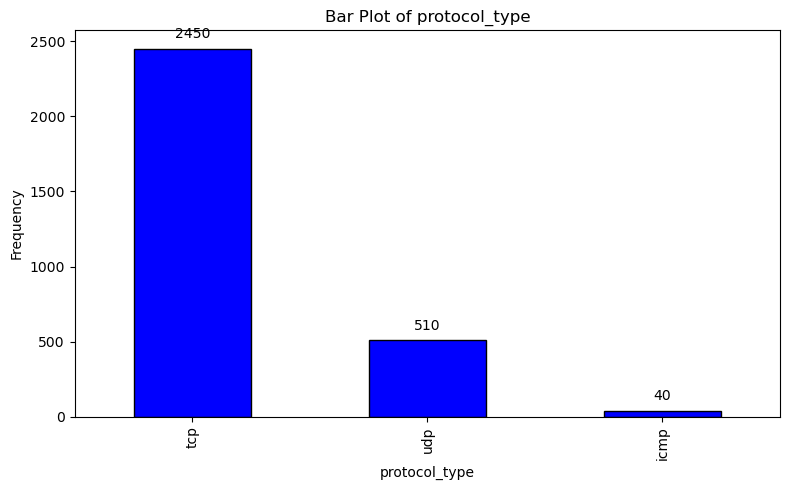

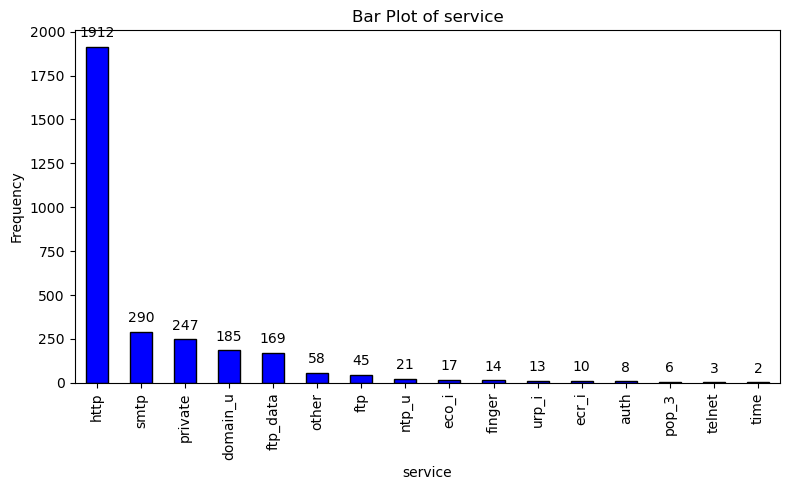

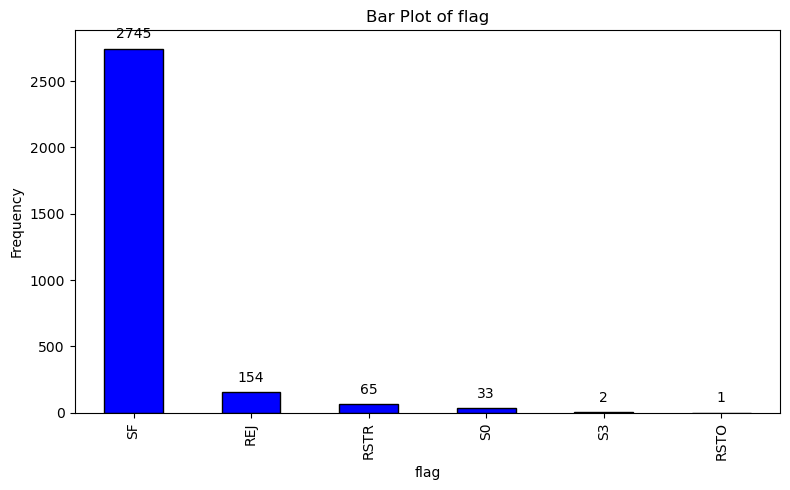

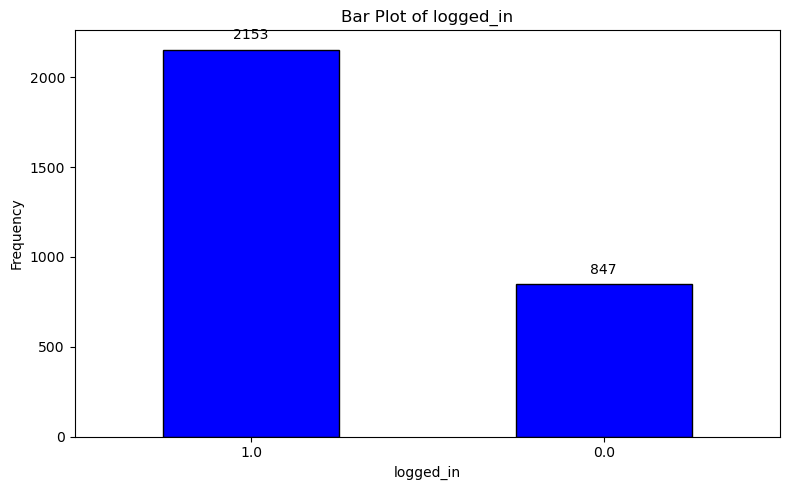

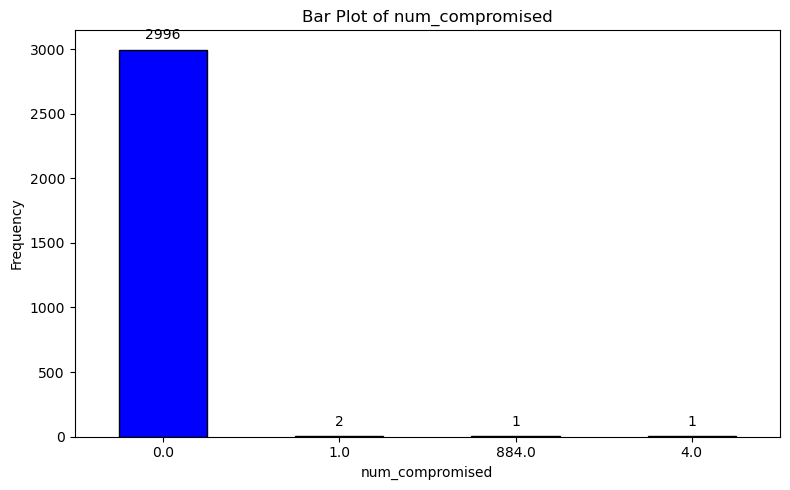

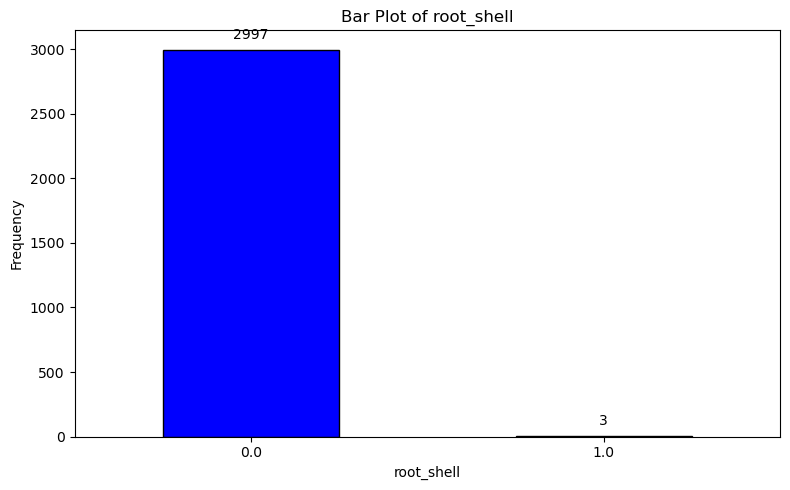

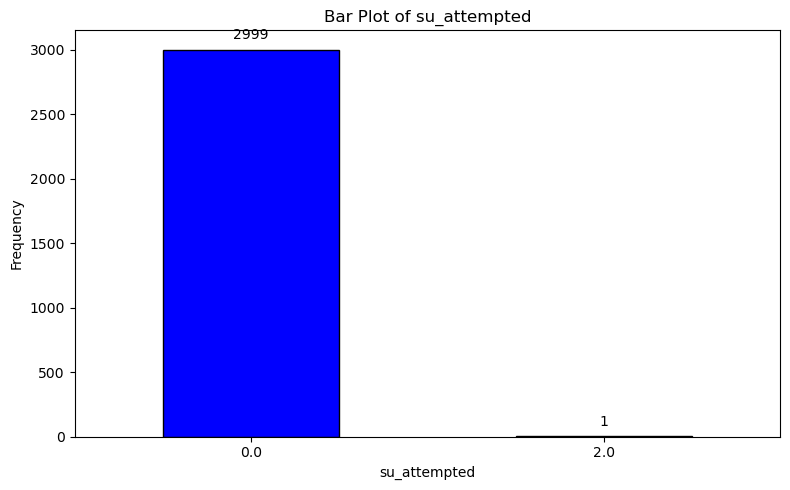

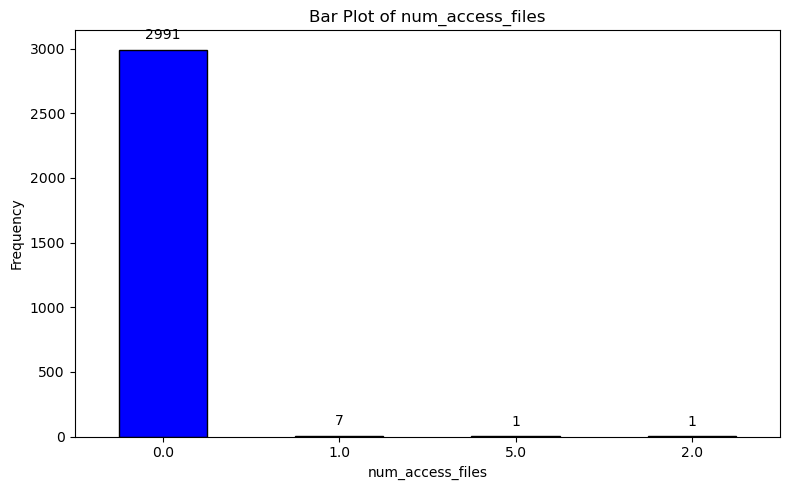

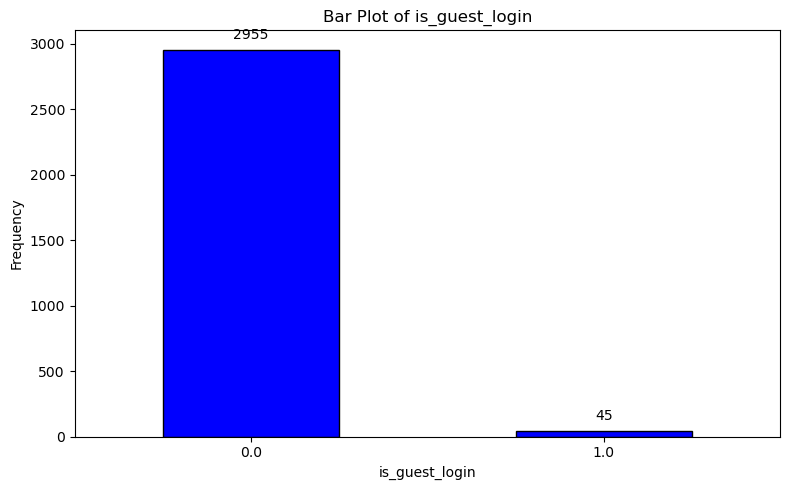

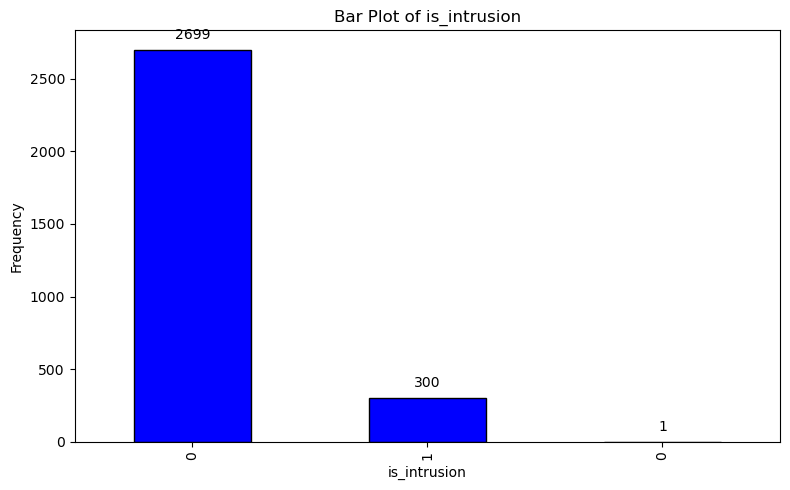

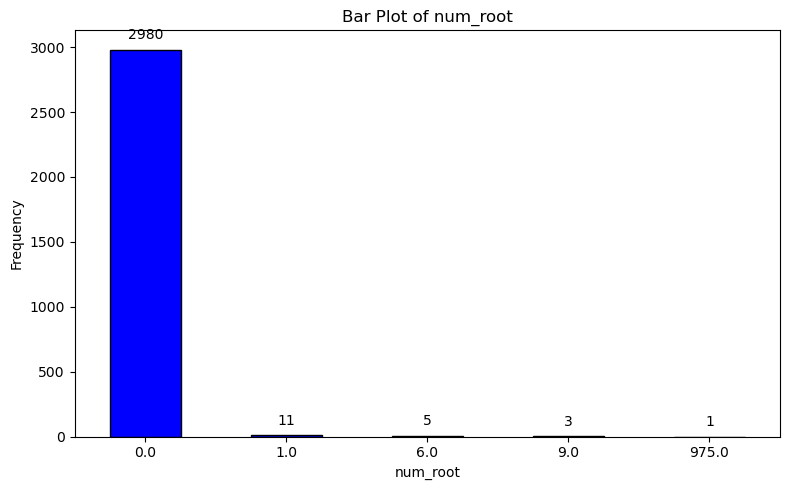

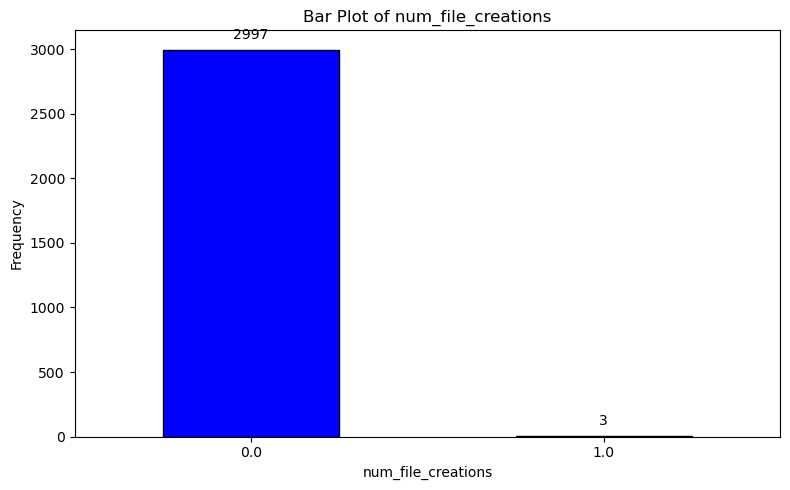

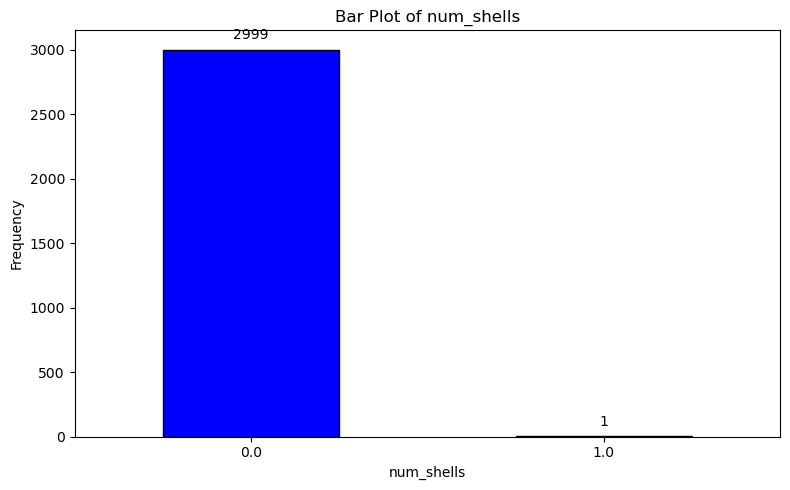

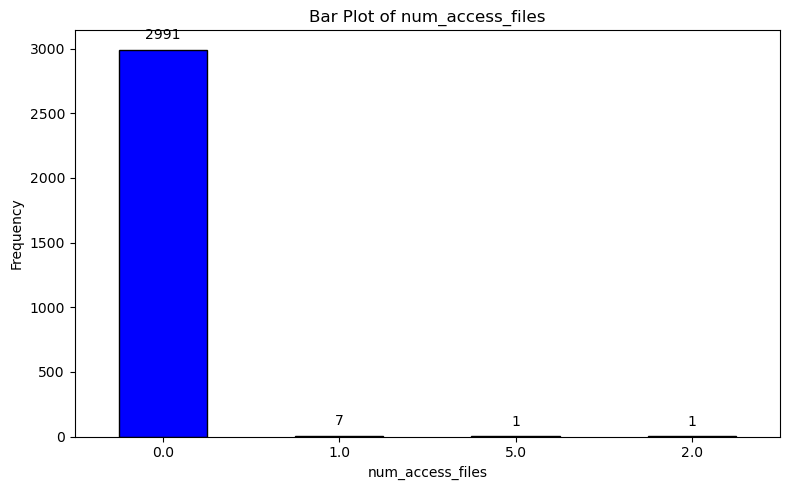

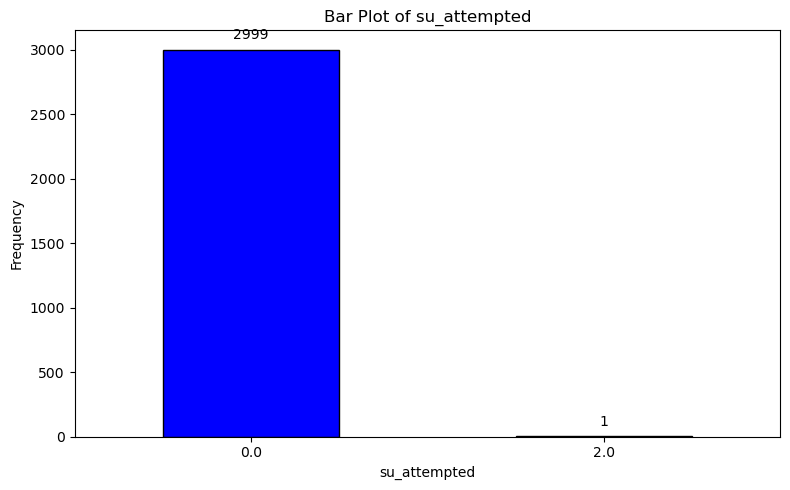

In [9]:

columns_to_plot = [
    'protocol_type', 'service', 'flag', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_access_files',
    'is_guest_login', 'is_intrusion', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'su_attempted'
]
for column in columns_to_plot:
    if column in df_clean.columns:  # Check if column exists
        plt.figure(figsize=(8, 5))
        # Count unique values for each column and plot
        counts = df_clean[column].value_counts()
        plot = counts.plot(kind='bar', color='blue', edgecolor='k')
        plt.title(f'Bar Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Adjust x-axis labels to display as integers
        if counts.index.dtype in ['int64', 'float64']:
            plt.xticks(rotation=0)  # Keep x-axis labels as numbers and upright for readability
        
        # Add value labels above each bar
        for index, value in enumerate(counts):
            plt.text(index, value + max(counts) * 0.02, str(value), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{column}' is not present in the DataFrame.")


In [16]:
from sklearn.preprocessing import LabelEncoder

# Apply LabelEncoder to each categorical column
label_encoders = {}
for column in df_clean.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_clean[column] = le.fit_transform(df_clean[column].astype(str))  # Convert to string to handle NaN
    label_encoders[column] = le  # Save encoder for inverse transformation if needed
df_clean.head()

/var/folders/xf/7vk65vw97qvgd7sw___tshsw0000gn/T/ipykernel_4229/2924870519.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = le.fit_transform(df_clean[column].astype(str))  # Convert to string to handle NaN
/var/folders/xf/7vk65vw97qvgd7sw___tshsw0000gn/T/ipykernel_4229/2924870519.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column] = le.fit_transform(df_clean[column].astype(str))  # Convert to string to handle NaN
/var/folders/xf/7vk65vw97qvgd7sw___tshsw0000gn/T/ipykern

,duration,protocol_type,service,flag,src_bytes,dst_bytes,hot,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_guest_login,is_intrusion
1,0.0,1,13,5,302.0,896.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1,13,5,339.0,1588.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,1,13,5,260.0,7334.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,1,13,5,213.0,8679.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,1,13,5,308.0,1658.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
# Split data into X and y
X = df_clean.drop(columns=['is_intrusion'])
y = df_clean['is_intrusion']

In [21]:
# Split data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Initialize scaler
scaler = StandardScaler()

# Apply scaling to the training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/Users/ninesb7/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ninesb7/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

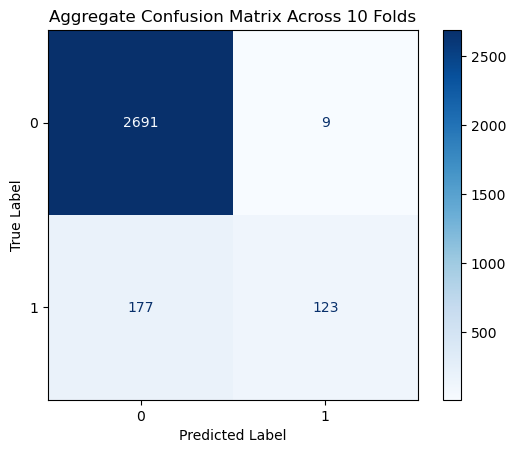

Average Accuracy across 10 folds: 0.938
Classification Report for Final Fold:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       270
           1       0.91      0.33      0.49        30

    accuracy                           0.93       300
   macro avg       0.92      0.66      0.73       300
weighted avg       0.93      0.93      0.91       300



In [25]:
# Initialize logistic regression model
lg = LogisticRegression(max_iter=1000)

# Set up 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to accumulate accuracy scores and the confusion matrices
accuracies = []
aggregate_cm = None  # Initialize aggregate confusion matrix as None

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    # Split data into train and test for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    lg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lg.predict(X_test)
    
    # Calculate accuracy and add to the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Generate confusion matrix for the current fold
    cm = confusion_matrix(y_test, y_pred)
    
    # Accumulate the confusion matrix across folds
    if aggregate_cm is None:
        aggregate_cm = cm  # Initialize aggregate_cm with the first fold's cm
    else:
        aggregate_cm += cm  # Add current fold's cm to aggregate_cm

# Plot the aggregate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=aggregate_cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Aggregate Confusion Matrix Across 10 Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display average accuracy across all folds
print("Average Accuracy across 10 folds:", np.mean(accuracies))
print("Classification Report for Final Fold:\n", classification_report(y_test, y_pred))


### USE SMOTE TECHNIQUE TO MAKE OUR DATASET MORE RELIABLE FOR MODELING

In [ ]:
# Initialize logistic regression model and SMOTE
lg = LogisticRegression(max_iter=1000)
smote = SMOTE(random_state=42)

# Set up 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Variables to accumulate accuracy scores and the confusion matrices
accuracies = []
aggregate_cm = None  # Initialize aggregate confusion matrix as None

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    # Split data into train and test for each fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train the model on the resampled (balanced) training data
    lg.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = lg.predict(X_test)
    
    # Calculate accuracy and add to the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Generate confusion matrix for the current fold
    cm = confusion_matrix(y_test, y_pred)
    
    # Accumulate the confusion matrix across folds
    if aggregate_cm is None:
        aggregate_cm = cm  # Initialize aggregate_cm with the first fold's cm
    else:
        aggregate_cm += cm  # Add current fold's cm to aggregate_cm

# Plot the aggregate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=aggregate_cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Aggregate Confusion Matrix Across 10 Folds with SMOTE")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display average accuracy across all folds
print("Average Accuracy across 10 folds:", np.mean(accuracies))
print("Classification Report for Final Fold:\n", classification_report(y_test, y_pred))